# TODO:

- loading and vrp gifs (later, not priority)
- joblib multiprocessing for all "for my_batch" loops?
- 

Notes:
- change state for final depot rotations (until all batches are done) to -1?
- store transitions via deepcopy
- compare the instances (n_vehicles, n_packages, n_dest) to Gendreau to pick similar vehicle packing levels?
- Alternatively train with a variety of packing levels (packages_perc_of_av_vol) -> closer to reality

In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../Data/')

import numpy as np
import random
import time
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

from gym import Env
from gym.spaces import Discrete, Box

from my_helper_functions import hf
from env_funcs import Vehicle
from itertools import repeat
from envs.gendreau_opt import TDCVRP

from joblib import Parallel, delayed
from itertools import repeat

import pprofile

Time to create env: 0.0 sec; 0.0 sec per batch
Time for step 0 (256 'parallel' instances, 3 destinations, 5 items): 0.74 sec (0.003 sec per instance)
Time for step 1 (256 'parallel' instances, 3 destinations, 5 items): 1.32 sec (0.005 sec per instance)
Time for step 2 (256 'parallel' instances, 3 destinations, 5 items): 2.4 sec (0.009 sec per instance)
Time for step 3 (256 'parallel' instances, 3 destinations, 5 items): 2.11 sec (0.008 sec per instance)
Time for step 4 (256 'parallel' instances, 3 destinations, 5 items): 0.12 sec (0.0 sec per instance)
Time for step 5 (256 'parallel' instances, 3 destinations, 5 items): 0.14 sec (0.001 sec per instance)


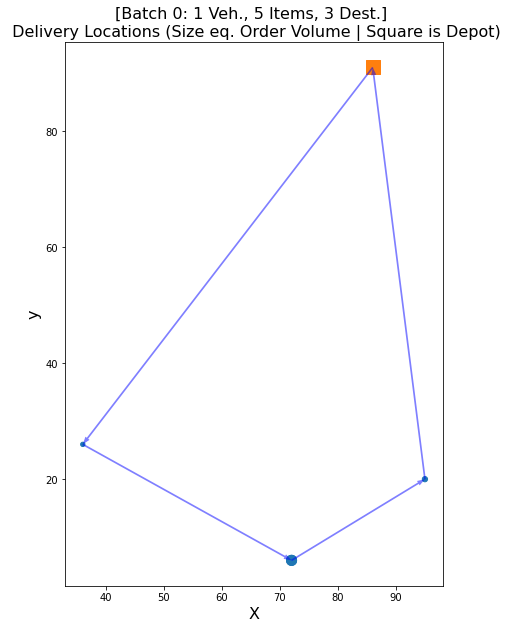

../src/envs/gendreau_opt.py:822: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


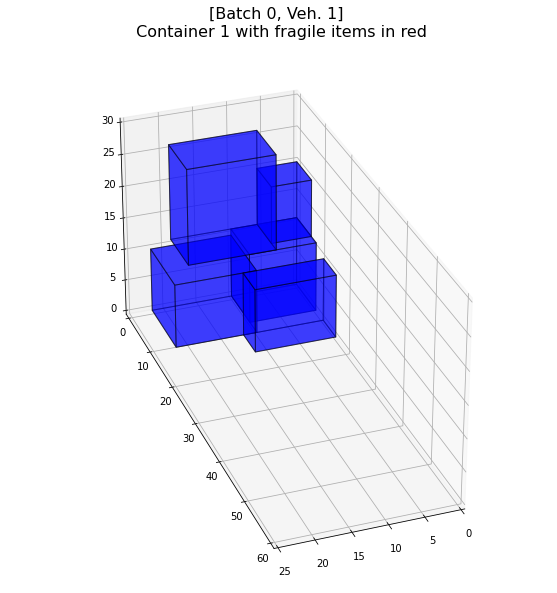

CPU times: user 7.57 s, sys: 1.78 s, total: 9.35 s
Wall time: 8.14 s


129.21484375

In [2]:
%%time

#%%prun # for profiling
np.random.seed(42)

# random agent testing
my_batch_size = 256

t = time.time()
env = TDCVRP(n_destinations=3, 
          packages_perc_of_av_vol=90,
          frag_freq_prob=15,
          test_set= 1,
          folder= "Test_folder",
          foldername= "Test_foldername",
          batch_size= my_batch_size,
          gendreau = None
         )



#env.reset()

delta_t = np.round((time.time() - t))
print("Time to create env: {} sec; {} sec per batch".format(delta_t, delta_t/env.batch_size))

episodes = 1
dist_coll = np.zeros(my_batch_size)
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 

    naive_action = 0
    done_iter = True
    counter = 0
    while done_iter:
        t = time.time()
        naive_action += 1

        
        actions = np.zeros([my_batch_size])

        for i in range(env.batch_size):
            
            random_agent = False # otherwise heuristic shortest distance
            
            if random_agent:
                flat_mask = env.mask[i].flatten(order = "F") # flatten by row!
                enumerates = np.arange(flat_mask.shape[0])
                logits = flat_mask / np.sum(flat_mask)
                actions[i] =np.random.choice(a=enumerates, replace=False, p=logits)
            
            else:
                # shorter distance random choice for visualization (REMOVE LATER)
                dist_manip = (env.mask[i, : , 0]  + env.state[i, :, 14]) *  env.mask[i, : , 0] + 999999 * (1-env.mask[i, : , 0])
                dist_manip[0] = 555555
                actions[i] = np.argmin(dist_manip)
                dist_coll[i] += min(dist_manip)
                

        #print("Mask \n", env.mask)
        #print("Actions taken: ", actions)
        #print("Dest Mask: ", env.same_dest_mask)
        #print("Feas Mask \n", env.feasibility_mask)
        

        #actions = agent.compute_action(state)

        n_state, reward, done, info = env.step(actions)
        state = n_state
        score+=reward
        done_iter = not all(done)

        #print(env.pandas_state(0))
        #print(env.pandas_state(1))

        print("Time for step {} ({} 'parallel' instances, {} destinations, {} items): {} sec ({} sec per instance)".format(counter, env.batch_size, env.n_destinations,env.state.shape[1]-1, np.round(time.time() - t, 2), np.round((time.time() - t)/env.batch_size, 3)))
        counter += 1
        #print("Rewards:", env.rewards)

    #print('Episode:{} Score:{}'.format(episode, score))

#print("Trajectory: \n", env.clean_trajectory)


longest_random_run = np.argmax(np.sum(env.clean_trajectory > 0, axis = 1))
env.disp_batch(batch = longest_random_run, truck = 0)
corrected = dist_coll - 555555

np.mean(corrected)

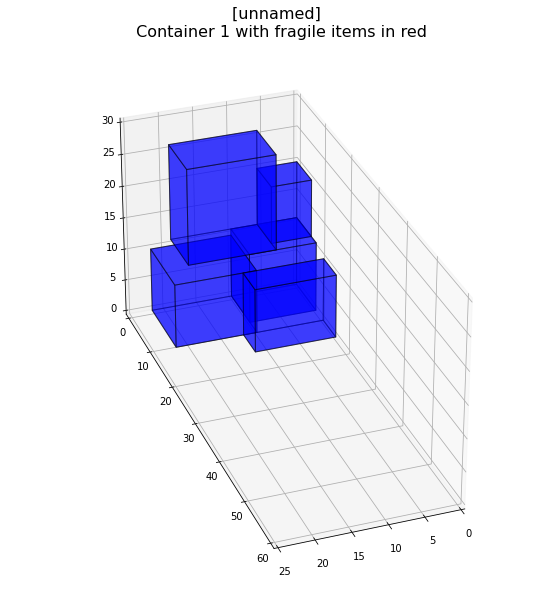

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [3]:
env.render_container(
        batch = 0,
        n_container = 0,
        fig_name="unnamed",
        save_plt=True,
        show_plt=True,
        n_limit=-1,
    )

In [4]:
#env.make_gif(batch=longest_random_run, my_title="random_agent", fps = 3)

In [5]:
#env.mask

In [6]:
# transform to l/n split
vol_map = np.zeros([env.batch_size, 100,100])

env.state[1, :, 1:3]
#np.sum(env.state[0, :, 3:6], axis = 1)

array([[46, 79],
       [23, 17],
       [12, 40],
       [40, 83],
       [40, 83],
       [40, 83]])

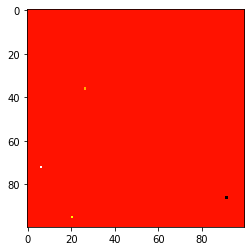

In [7]:
import matplotlib.pyplot as plt
vol_map = np.zeros([env.batch_size, 100,100])
for my_batch in range(env.batch_size):
    my_ind = env.state[my_batch, :, 1:3]
    my_volumes = env.state[my_batch, :, 3]*env.state[my_batch, :, 4]*env.state[my_batch, :, 5]
    my_volumes[0] = -1000
    vol_map[my_batch, my_ind[:,0], my_ind[:,1]] += my_volumes


plt.imshow(vol_map[0], cmap='hot', interpolation='nearest')

In [8]:
def get_lin_df(my_env):
    simple_model_info = np.zeros([my_env.batch_size, 5])
    my_num_items = my_env.state.shape[1] - 1
    simple_model_info[:, 0] = my_num_items
    my_volumes = my_env.state[:, :, 3]*my_env.state[:, :, 4]*my_env.state[:, :, 5]
    simple_model_info[:, 1] = np.sum(my_volumes, axis = 1)
    my_fragile = np.sum(env.state[:, : , 6], axis = 1)
    simple_model_info[:, 2] = my_fragile
    stdx = np.std(my_env.state[:, : , 1], axis = 1)
    stdy = np.std(my_env.state[:, : , 2], axis = 1)
    simple_model_info[:, 3] = stdx
    simple_model_info[:, 4] = stdy

    return simple_model_info

get_lin_df(env)

array([[5.00000000e+00, 4.68400000e+03, 0.00000000e+00, 1.83522630e+01,
        3.01685082e+01],
       [5.00000000e+00, 4.21700000e+03, 0.00000000e+00, 1.19408263e+01,
        2.61177887e+01],
       [5.00000000e+00, 4.91600000e+03, 1.00000000e+00, 2.32552264e+01,
        1.38774397e+01],
       ...,
       [5.00000000e+00, 4.70900000e+03, 1.00000000e+00, 3.60555128e+01,
        3.16881506e+01],
       [5.00000000e+00, 3.79600000e+03, 2.00000000e+00, 2.91571413e+01,
        2.80500545e+01],
       [5.00000000e+00, 6.14900000e+03, 1.00000000e+00, 2.34946802e+01,
        2.71579741e+01]])

In [9]:
from sklearn.linear_model import LinearRegression
target = np.random.randint(0,10,env.batch_size)

reg = LinearRegression().fit(simple_model_info, target)
reg.score(simple_model_info, target)

reg.coef_

#reg.intercept_

#reg.predict(np.random.randint(0,10,5).reshape(1, -1))

NameError: name 'simple_model_info' is not defined

In [ ]:
np.random.randint(0,10,5).reshape(1, -1)

In [ ]:
env.rewards

In [ ]:
np.random.randint(0,10,11)

In [ ]:
env.containers[:, 0].reshape((env.batch_size, -1))

In [ ]:
np.sum((env.state[0, :, 15]>=1)*(-1)+1)

In [13]:
env.pandas_state(0)

,dest,x,y,h,w,l,frag,pos_h,pos_w,pos_l,pos_h_r,pos_w_r,pos_l_r,rot,d_prev,n_veh,seq_nr,l_skip,l_skip_r,feas,feas_r,feas_same,depot_mask,mask_n,mask_r
0,0,86,91,0,0,0,0,-1,-1,-1,-1,-1,-1,0,0,1,7,0,0,1,1,1,1,1,1
1,1,95,20,11,10,8,0,0,0,0,-1,-1,-1,0,71,1,2,0,0,0,0,1,0,0,0
2,2,36,26,10,12,5,0,0,0,11,-1,-1,-1,0,82,1,6,10,7,0,0,1,0,0,0
3,3,72,6,10,12,11,0,0,10,0,-1,-1,-1,0,86,1,3,0,0,0,0,1,0,0,0
4,3,72,6,9,6,6,0,11,0,0,-1,-1,-1,0,86,1,4,0,0,0,0,1,0,0,0
5,3,72,6,15,13,8,0,11,6,0,-1,-1,-1,0,86,1,5,0,0,0,0,1,0,0,0


In [ ]:
my_dict = dict()
my_dict[0] = 2
my_dict[5] = 5

In [ ]:
if (my_dict):
    print("x")

In [ ]:
my_list = list()
my_list.append(5)
my_list.append(0)
my_dict[min(my_list)]

In [ ]:
container = env.containers[0, 0]
h_arange = abs(np.arange(container.shape[0]))[:, np.newaxis] + 100
l = 0
# do not forget to reduce h etc to range max - 1
h_check = abs(container[:,:,l]) * h_arange
hs_for_l = np.argmin(h_check, axis = 0)
hs_for_l

# if hs 0 and whl 0 then skip to next w

In [ ]:
for i in range(5):
    print(i)

In [ ]:
hs_for_l.tolist()[0]

In [ ]:
env.pandas_state(0)